# M1. Actividad

**Nombre:** Diego Antonio García Padilla.

**Matrícula:** A01710777.

## Descripción del Sistema de 'Recolección de Alimentos'

### Objetivo del Sistema

Desarrollar un sistema donde agentes llamados 'exploradores' buscan comida y la llevan de vuelta a su base. Los exploradores se desplazan buscando celdas con alimentos y regresan a la base una vez que encuentran un recurso.

### Características del Sistema:

- **Energía del Explorador:** Cada explorador comienza con una energía máxima de X unidades, y cada movimiento consume 1 unidad de energía. Al llegar a la base, el explorador recarga completamente su energía.
- **Ubicación de la Base:** La base siempre se encuentra en el centro del área de búsqueda.
- **Parámetros del Sistema:**
  - Un área de NxN celdas.
  - Un número específico de exploradores.
  - Una base fija en una celda determinada.
  - Un número de recursos.
  - Un máximo de energía que los exploradores pueden tener.

### Distribución de Agentes y Recursos:

- Tanto los agentes como los recursos se distribuyen aleatoriamente al inicio de la simulación.

### Comportamiento por Paso:

- Si la celda contiene recursos, el agente los recoge y regresa a la base.
- Si la celda no contiene recursos, el agente elige una dirección aleatoria para moverse (una de las 4 celdas vecinas) a una celda sin otro agente. Si no puede moverse allí, permanecerá en la misma celda.

## Instrucciones para la Simulación y el Análisis:

### Simulación Inicial:

- Ejecuta una simulación para una matriz de 11x11 con 5 exploradores y 20 recursos.
- Todos los agentes deben empezar con 100 unidades de energía.
- Muestra gráficamente el comportamiento del modelo.

### Análisis de Eficiencia:

- Analiza cómo la cantidad de exploradores y recursos influye en la eficiencia de la recolección de recursos.
- La eficiencia se medirá observando la cantidad de energía que cada explorador consume durante el proceso de búsqueda y recolección de recursos.
- Para ello, realiza pruebas en un espacio de 15x15 con:
  - 5 y 10 exploradores.
  - 15, 20 y 30 recursos.
- Presenta los hallazgos en el informe, incluyendo gráficos y tablas según sea necesario.

# Instalación e importación de librerías

In [25]:
# Descargar mesa y seaborn
%pip install mesa seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [26]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# BATCH_RUNNER
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Definición de clases de Agente y Modelo

In [ ]:
class Explorer(Agent):
    """
    Agente que recolecta comida.
    """

    def __init__(self, id, model, max_energy):
        """
        Constructor de la clase Explorer.
        """

        # Inicializamos la clase padre Agent
        super().__init__(id, model)

        # Atributos del agente
        self.model = model
        self.max_energy = max_energy
        self.energy = max_energy
        self.food = 0
        

    def move(self):
        """
        Método que define el comportamiento del agente.
        """

        # Obtener las celdas vecinas
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = False,
            include_center = False)

        # Obtener indices del arreglo de posiciones posibles y desordenarlos
        indexes = [x for x in range(len(possible_steps))]
        np.random.shuffle(indexes)

        # Recorrer las celdas vecinas
        for i in indexes:
            next_step = possible_steps[i]

            # Si la celda está vacía, moverse a ella
            if self.model.grid.is_cell_empty(next_step):
                self.model.grid.move_agent(self, next_step)

                # Actualizar la energía del agente
                self.energy -= 1

                break
        
    
    def step(self):
        """
        Paso de simulación para el agente.
        """

        # Obtener la posición actual del agente
        (x, y) = self.pos

        # Comprobar si tiene energía
        if self.energy == 0:
            return 

        # Si la celda tiene comida y el agente no tiene comida, tomarla y moverse
        if self.model.cells[x][y] == 1 and self.food == 0:
            self.model.cells[x][y] = 0
            self.food = 1
            self.move()
        # Si la celda es la base, recargar energía y moverse
        elif self.model.cells[x][y] == 2:
            self.energy = self.max_energy

            # Si el agente tiene comida, dejarla en la base
            if self.food == 1:
                self.food = 0
                self.model.food += 1

            self.move()
        # Si la celda no tiene comida, moverse
        else:
            self.move()

In [28]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for content, (x, y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]
        if content != None:
            grid[x][y] = 3
    return grid

In [29]:
class World(Model):
    """
    Modelo del mundo donde los agentes recolectan comida.
    """

    def __init__(self, width = 11, height = 11, num_agents = 5, num_food = 20):
        """
        Constructor de la clase World.
        """

        # Inicializamos la clase padre Model
        super().__init__()

        # Pasos de la simulación
        self.steps = 0

        # Comida recolectada
        self.food = 0

        # Grid de la simulación
        self.grid = SingleGrid(width, height, torus = False)

        # Método de activación de los agentes
        self.schedule = SimultaneousActivation(self)

        # Ubicación de la base
        self.base = (width // 2, height // 2)

        # Inicializar celdas
        self.cells = np.zeros((width, height))

        # Agregar comida al mundo
        for _ in range(num_food):
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)
            self.cells[x][y] = 1

        # Agregar agentes al mundo
        for i in range(num_agents):
            agent = Explorer(i, self, 100)
            self.schedule.add(agent)
            self.grid.move_to_empty(agent)
        
        # Definir base
        self.cells[self.base[0]][self.base[1]] = 2

        # Recolectar datos
        self.datacollector = DataCollector(
            model_reporters = {
                "Grid": get_grid,
                "Steps": lambda m: m.steps,
                "Food": lambda m: sum(int(m.cells[x][y] == 1) for x in range(width) for y in range(height)),
                },
            agent_reporters = {
                "Energy": "energy",
                "Food": "food"
                }
        )

    def are_food(self):
        """
        Método que verifica si hay comida en el mundo.
        """

        return sum(int(self.cells[x][y] == 1) for x in range(self.grid.width) for y in range(self.grid.height)) > 0
    
    def are_agents_alive(self):
        """
        Método que verifica si hay agentes vivos en el mundo.
        """

        return sum(agent.energy > 0 for agent in self.schedule.agents) > 0
    
    def game_over(self):
        """
        Método que verifica si la simulación ha terminado.
        """

        return not self.are_agents_alive() or not self.are_food()
    
    def step(self):
        """
        Método que define el comportamiento de los agentes en un paso de la simulación.
        """

        # Comprobar que hay agentes vivos y comida en el mundo
        if not self.game_over():
            self.steps += 1
        
        # Recolectar datos
        self.datacollector.collect(self)

        # Activar a los agentes
        self.schedule.step()

In [30]:
X, Y = 11, 11
AGENTS = 5
FOOD = 20

# Inicializar el modelo
model = World(X, Y, AGENTS, FOOD)

# Ejecutar el modelo
while not model.game_over():
    model.step()

print("Modelo terminado en", model.steps, "pasos")
print("Comida recolectada:", model.food)

Modelo terminado en 148 pasos
Comida recolectada: 1


In [31]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head()

,Grid,Steps,Food
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,19
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,18
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,18
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,18
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5,17


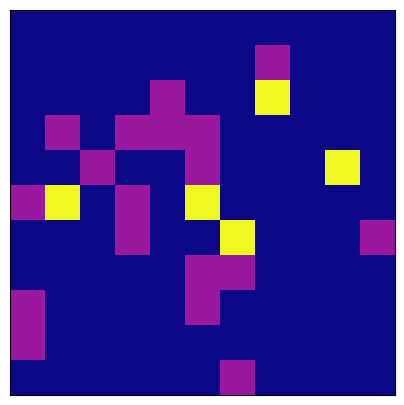

In [32]:
fig, axs = plt.subplots(figsize=(5, 5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.plasma)

def animate(i):
  patch.set_data(all_grids.iloc[i,0])


anim = animation.FuncAnimation(fig, animate, frames=range(len(all_grids)), repeat=False)
anim



In [33]:
params = {
    "width": 11,
    "height": 11,
    "num_agents": 5,
    "num_food": 20
}

STEPS = 1000
ITERATIONS = 5

results = batch_run(
    World,
    parameters = params,
    iterations = ITERATIONS,
    max_steps = STEPS,
    number_processes = 1,
    data_collection_period=1,
    display_progress=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
df = pd.DataFrame(results)
data = df[(df.Step == STEPS)].drop(
    ['iteration','Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [35]:
data.head()

,RunId,Steps,Food,AgentID,Energy
5000,0,121,1,0,0
5001,0,121,1,1,0
5002,0,121,1,2,0
5003,0,121,1,3,0
5004,0,121,1,4,0


In [36]:
data.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps','Food']]

Steps             Food         
          min   mean  max  min mean max
AgentID                                
0         121  225.8  430    1  1.0   1
1         121  225.8  430    1  1.0   1
2         121  225.8  430    1  1.0   1
3         121  225.8  430    0  0.8   1
4         121  225.8  430    1  1.0   1